In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import math
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler #para escalar caracteristicas
from sklearn.model_selection import train_test_split # separar mas facil la data de train y test

# Convolutional Neural Network
Tambien conocida como ConvNet, son similares a las redes normales, pero estan formados por neuronas que tienen ponderaciones y sesgos. Util en la clasificación de imagenes. Usualmente suelen usarse ademas de capas convulicionales, la capas de pooling utilizadas para aprender automaticamente algunas caracteristicas de las imagenes. Al final de estas redes suelen haber varias Fully Conected Layers destinadas a presentar la clasificación predecida final.

¿ Para que son los filtros Pooling?
En la practica toman varios numeros que representan pixeles de una imagen y los ponderan de alguna forma, es decir detecta la caracteristica mas importante de un grupo de pixeles. De paso representa la imagen en menor tamaño. A veces se usan tecnicas de Padding previo a la imagen para poder aplicar un filtro de mayor tamaño. El pooling mas utilizado es el Max (ver ejemplo: https://computersciencewiki.org/index.php/Max-pooling_/_Pooling).
* En sintesis reduce el Pooling sirve para reducir el costo computacional al reducir el tamaño de la imagen, lo cual tambien rduce el numero de parametros. Tambien ayuda al sobreajuste, porporcionando una forma "abstrabta" del input.

Lo bueno esque con pytorch es mas facil de aplicar.

### Ejemplo
Se utilizará un Dataset el cual contiene muchisimas fotos y se intentaran predecir si son aviones, autos, pajaros, gatos, ciervos, perros, ranas, caballos, barcos o camiones. Este Dataset es muy famoso (CIFAR-10) y esta disponible con pytorch.


## Device config

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Esto garantiza que se ejecutara en GPU si esta disponible
print(device)

cpu


## Hyperparametros

In [6]:
num_epochs = 4
batch_size = 5
learning_rate = 0.01

## MNIST Data

In [7]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Optimizacion de lotes y train facil haciedno esto como ya hemos visto
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


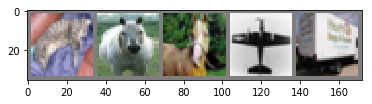

In [8]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Neuronal Networks
Aqui se arma la red neuronal, con Conv2d. También se define el modelo

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # SE DEFINEN LAS CAPAS A UTILIZAR, TANTO LAS CNN, FCL-ANN CY LAS DE POOLING
        ## FEATURE LEARNING: sección donde se aprenden caracteristicas importantes de las imagenes
        # Definimos la primera capa convolucional
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # 3 canales (RGB), 6 Canales producido por la convolucion (salida),
        # Tamaño de esas salidas 5x5 (si se quiere algo no cuadrado la entrada debe ser como tupla)
        
        # Filtro Max Pooling
        ## Pooling de tamaño 2 y "que avanza" de a 2 "cuadros" (ver ejemplo para entender mejor
        # que es el stride)
        self.pool = nn.MaxPool2d(2, stride=2)
        
        # Segunda capa convolucional
        # 6 canales de entrada, 16 Canales producido por la convolucion (salida),
        # Tamaño de esas salidas 5x5 (si se quiere algo no cuadrado la entrada debe ser como tupla)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        ## CLASIFICATION: Sección hecha con Fully Connected Layers destinadas a la parte de clasificación
        #Aquí ya todo es "plano"
        # Primera red neuronal comun, debemos pasar todo los datos a un nivel "plano". Cada canal producido 
        # Conv2d anterior debe tenerse en cuenta, y cada uno tiene tamaño 5x5, 
        # por ende la entrada debe ser 5x 5 x 16
        ### Diremos que la salida de este neuron 120, este valor es opcional y puede ser cambiado pero si
        ### si cambia DBE CAMBIARSE TAMBIEN EL DE LA SIGUIENTE NEURON
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Segundo Neuron lineal, recibe como entrada los 120 salidas del neuron anterior, y entrega
        ## 84 salidas
        self.fc2 = nn.Linear(120, 84)
        # Tercer neuron lineal, recibe como entrada los 84 salidas y entrega 10 salidas, que corresponden
        # al os valores finales de clasificacion previos al Softmax-CrossEntropu
        self.fc3 = nn.Linear(84, 10)
        
        
        #Se pueden agregar mas capas o mas neurones, cambiar tamaños etc.. pero siempre debo terminar con
        # una salida del tamaño que busco

    def forward(self, x):
        # Aquí aplicaremos las funciones de activación y los POOLING entre capas
        ## Entrada
        # -> n, 3, 32, 32
        
        # Se utiliza la primera CNN que se definio + Aplicar F.A Relu + Pooling definido arriba
        # queda -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv1(x)))  
        # Se utiliza la SEGUNDA CNN que se definio + Aplicar F.A Relu + Pooling definido arriba
        # queda -> n, 16, 5, 5
        x = self.pool(F.relu(self.conv2(x)))  
        # APLANAMOS TODO (osea reshape) para poder pasar a la primera capa de la FCL
         # queda -> n, 400
        x = x.view(-1, 16 * 5 * 5)           
        # Se utiliza LA PRIMERA FCL-ANN que se definio + Aplicar F.A Relu, ya no se necesita pooling
        # queda  -> n, 120
        x = F.relu(self.fc1(x))
        # Se utiliza LA SEGUNDA FCL-ANN que se definio + Aplicar F.A Relu
        # queda   -> n, 84
        x = F.relu(self.fc2(x))
        # Se utiliza LA SEGUNDA FCL-ANN que se definio
        # RECORDAR QUE LA CROSS ENTROPY CON PYTORCH YA HACE LA ULTIMA FUNCIÓN DE ACTIVACIÓN: EL SOFTMAX
        # queda -> n, 10
        x = self.fc3(x)
        return x


model = ConvNet().to(device)
    

## Loss y optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training Loop

In [11]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [200/10000], Loss: 2.2693
Epoch [1/4], Step [400/10000], Loss: 2.3427
Epoch [1/4], Step [600/10000], Loss: 2.3262
Epoch [1/4], Step [800/10000], Loss: 2.3146
Epoch [1/4], Step [1000/10000], Loss: 2.3788
Epoch [1/4], Step [1200/10000], Loss: 2.3424
Epoch [1/4], Step [1400/10000], Loss: 2.3004
Epoch [1/4], Step [1600/10000], Loss: 2.3602
Epoch [1/4], Step [1800/10000], Loss: 2.3327
Epoch [1/4], Step [2000/10000], Loss: 2.2969
Epoch [1/4], Step [2200/10000], Loss: 2.2962
Epoch [1/4], Step [2400/10000], Loss: 2.2994
Epoch [1/4], Step [2600/10000], Loss: 2.3243
Epoch [1/4], Step [2800/10000], Loss: 2.3022
Epoch [1/4], Step [3000/10000], Loss: 2.2913
Epoch [1/4], Step [3200/10000], Loss: 2.3023
Epoch [1/4], Step [3400/10000], Loss: 2.3212
Epoch [1/4], Step [3600/10000], Loss: 2.3003
Epoch [1/4], Step [3800/10000], Loss: 2.3275
Epoch [1/4], Step [4000/10000], Loss: 2.2773
Epoch [1/4], Step [4200/10000], Loss: 2.2960
Epoch [1/4], Step [4400/10000], Loss: 2.2690
Epoch [1/4], S

Epoch [4/4], Step [6600/10000], Loss: 1.8783
Epoch [4/4], Step [6800/10000], Loss: 0.8712
Epoch [4/4], Step [7000/10000], Loss: 2.1036
Epoch [4/4], Step [7200/10000], Loss: 1.2352
Epoch [4/4], Step [7400/10000], Loss: 1.5570
Epoch [4/4], Step [7600/10000], Loss: 1.1658
Epoch [4/4], Step [7800/10000], Loss: 2.0200
Epoch [4/4], Step [8000/10000], Loss: 1.8572
Epoch [4/4], Step [8200/10000], Loss: 1.7974
Epoch [4/4], Step [8400/10000], Loss: 1.4490
Epoch [4/4], Step [8600/10000], Loss: 1.7215
Epoch [4/4], Step [8800/10000], Loss: 1.7022
Epoch [4/4], Step [9000/10000], Loss: 1.6558
Epoch [4/4], Step [9200/10000], Loss: 1.5017
Epoch [4/4], Step [9400/10000], Loss: 1.9075
Epoch [4/4], Step [9600/10000], Loss: 2.0387
Epoch [4/4], Step [9800/10000], Loss: 1.6806
Epoch [4/4], Step [10000/10000], Loss: 1.4951
Finished Training


## Testing evaluation

In [19]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        print(images.shape)
        print(labels.shape)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        print(_)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
        
        

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5452, 5.0059, 3.6254, 3.5797, 1.8589])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2373, 2.1827, 2.8021, 2.3371, 3.9120])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.3677, 3.7934, 1.6535, 1.6697, 3.8011])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5988, 3.3573, 1.0859, 4.0655, 2.7352])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9662, 5.0251, 2.8659, 4.1963, 2.8270])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4090, 3.0977, 2.1161, 2.8484, 2.7430])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0351, 1.7244, 1.3554, 2.7307, 3.1336])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.1491, 1.8980, 3.7863, 3.2943, 2.1736])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8147, 2.4923, 2.6433, 3.1673, 3.4141])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2028, 2.8730, 1.4507, 2.5762, 2.7331])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.4527, 1.6370, 2.4612, 2.048

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7207, 0.8068, 5.4771, 2.2218, 3.1312])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2824, 3.9752, 2.6193, 2.0255, 3.0904])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8169, 2.7091, 1.1858, 1.8969, 2.1512])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2103, 2.3043, 1.6777, 2.3778, 1.2414])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4683, 1.5428, 1.1382, 1.9917, 1.3536])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.3495, 1.6849, 5.7855, 2.3571, 3.3243])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0369, 2.3161, 3.2018, 2.5664, 2.4330])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.7378, 2.8799, 2.5986, 2.2362, 1.2085])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.0174, 3.6888, 1.2136, 1.3443, 3.0928])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2686, 2.0499, 4.0759, 2.9426, 4.4121])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.6778, 2.1448, 3.9189, 2.159

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3337, 3.8995, 2.5078, 2.4253, 2.2927])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.8101, 2.4628, 0.9560, 2.1413, 3.4346])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6394, 1.4491, 3.2073, 1.9649, 1.9629])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5274, 6.7589, 1.9422, 2.0836, 3.1889])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4318, 2.9526, 1.5361, 2.0933, 1.9472])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.6952, 0.5221, 3.7608, 3.7926, 1.7489])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2050, 4.4108, 1.9772, 2.3102, 1.1856])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.0108, 1.1461, 1.2027, 2.8547, 4.4061])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.2660, 2.1177, 1.5556, 2.1861, 3.3366])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8230, 1.9446, 2.9373, 2.0518, 1.4513])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.3976, 1.4863, 3.7802, 3.456

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3766, 1.8263, 2.3107, 2.6120, 2.3375])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8375, 1.5520, 1.6579, 3.5748, 1.5251])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2178, 1.6527, 5.1650, 1.2446, 3.1844])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.3196, 2.7965, 1.6279, 0.9845, 2.1782])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1442, 1.2416, 5.2883, 3.2180, 4.4154])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4734, 1.5730, 1.5214, 4.4556, 2.5185])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.6265, 5.0127, 2.2763, 1.6417, 3.8879])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0573, 4.6913, 3.4533, 2.6294, 3.6134])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7563, 4.5767, 0.8698, 2.2102, 1.2680])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8111, 0.5710, 3.4518, 1.4108, 2.5333])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.4914, 1.1152, 5.7030, 2.003

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6309, 4.0136, 1.9196, 3.2010, 4.6248])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.1897, 3.4135, 2.1961, 3.2259, 2.0953])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1210, 1.8270, 5.4770, 3.3323, 1.8404])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4149, 3.6329, 4.9711, 1.1819, 0.9679])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6858, 2.4099, 2.8705, 1.5836, 1.7609])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6169, 4.3956, 1.4951, 3.0512, 1.5579])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.0370, 2.9287, 2.9319, 1.1067, 4.7326])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7267, 0.8656, 3.3367, 2.8071, 4.0257])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.6745, 2.9584, 1.8927, 3.3730, 3.3653])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3114, 3.4935, 2.0454, 1.3724, 4.1419])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.2617, 4.6653, 1.2842, 7.079

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7004, 3.5592, 2.2242, 2.7592, 1.6396])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6959, 2.3057, 3.2503, 3.7597, 2.5438])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1704, 1.2479, 2.4235, 2.5457, 2.5588])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.1554, 3.7205, 1.8210, 1.9132, 3.0018])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3393, 1.5786, 2.1560, 0.7608, 2.6540])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4943, 2.7585, 1.7705, 2.4299, 2.1583])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9779, 1.2882, 0.9759, 3.0217, 2.5667])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6864, 1.4450, 1.7015, 3.2398, 3.0540])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.0097, 3.7985, 3.2525, 1.4327, 1.8488])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9979, 4.0377, 2.7967, 1.4545, 3.8738])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5796, 4.8337, 4.8010, 2.433

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4144, 1.3429, 1.3686, 1.0273, 2.9398])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1890, 2.0400, 2.0703, 3.0238, 1.9139])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.7539, 1.8876, 1.7896, 3.5494, 2.8577])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9737, 2.5042, 5.5582, 2.2887, 2.7332])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([0.6920, 3.3729, 4.4031, 3.9454, 4.9271])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3777, 1.9488, 1.8085, 3.8090, 3.2281])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8821, 2.9203, 2.3158, 5.5896, 2.4582])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8805, 2.8346, 2.3997, 0.9512, 2.1562])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1217, 2.3813, 2.6479, 5.9507, 3.6643])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.5722, 1.9267, 1.7233, 1.1549, 2.5710])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([0.9667, 2.6703, 1.8438, 2.140

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2295, 2.1678, 2.9010, 2.5497, 1.6894])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6979, 2.3603, 3.0538, 0.9006, 1.1125])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3889, 4.0829, 1.6244, 3.2653, 1.9050])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1039, 2.9289, 2.2440, 1.2290, 2.6166])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9591, 1.7360, 1.6637, 4.3608, 0.9080])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9994, 2.9296, 2.1556, 2.9371, 2.6885])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8701, 1.6144, 1.9542, 2.2995, 2.7509])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.3668, 4.7709, 1.7309, 5.0892, 2.8127])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4881, 3.1467, 3.7770, 4.8182, 2.3708])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1299, 4.5119, 2.7160, 1.2931, 1.9241])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7684, 3.2826, 1.3576, 1.568

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.2922, 3.7385, 6.0008, 1.7851, 1.5316])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9116, 2.8102, 2.0490, 5.0610, 2.6956])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1523, 1.7754, 2.3739, 2.6719, 1.3619])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5981, 1.7320, 4.2167, 1.8358, 4.6969])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5105, 2.2063, 3.6235, 5.8785, 2.9104])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.1438, 2.8539, 1.5973, 2.4133, 1.8429])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2924, 2.9968, 3.7889, 1.7708, 2.1300])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6826, 2.9698, 1.9233, 2.9094, 1.9402])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9293, 2.2375, 1.8187, 2.4910, 2.9035])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4049, 1.2368, 3.2855, 2.2965, 4.3151])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3599, 3.8698, 3.8898, 2.652

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4144, 3.0583, 1.8098, 3.3337, 2.0658])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5332, 1.0926, 2.5210, 2.1494, 3.3137])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.0320, 3.8882, 1.4513, 2.9979, 1.8881])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.4560, 2.0821, 3.7725, 1.3455, 2.2739])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8220, 3.0424, 3.1806, 5.5019, 1.9590])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.5653, 1.0042, 2.5719, 1.5859, 2.8830])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1441, 2.5783, 5.5307, 4.0030, 1.7473])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([8.0892, 1.9007, 2.3254, 1.0245, 2.1782])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7281, 2.9562, 2.1985, 1.7148, 3.1939])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4355, 0.9689, 2.0737, 2.2083, 3.3166])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7589, 4.4573, 1.7066, 1.452

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4451, 3.2839, 1.9187, 6.8878, 3.1257])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.1549, 2.9865, 2.2918, 2.0584, 4.5761])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5249, 5.4526, 3.3381, 2.3084, 1.9061])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8058, 3.3559, 0.8901, 1.6714, 2.3619])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6510, 2.3597, 2.4154, 2.1777, 5.3831])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0702, 2.0469, 2.0562, 2.6919, 2.2451])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3383, 6.0059, 2.4004, 1.0390, 2.9027])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1861, 2.6264, 2.1242, 2.6626, 2.4291])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5189, 2.0766, 4.8306, 1.6739, 3.4294])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8535, 4.2177, 4.3379, 4.7738, 0.9996])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4409, 3.5278, 1.3155, 2.068

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.5389, 2.1378, 2.8850, 1.7660, 1.3780])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0402, 4.6247, 2.8499, 1.2290, 2.6800])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.1243, 2.3568, 2.5570, 1.0221, 3.7348])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4272, 6.5192, 5.5725, 5.1563, 2.5171])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.4373, 2.1952, 1.5245, 1.8688, 3.3204])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5853, 1.8339, 2.8866, 2.2005, 2.4392])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5988, 1.9190, 3.4912, 3.8323, 2.7154])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1555, 5.6968, 5.1938, 2.9321, 2.8280])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3034, 1.9998, 1.5136, 2.3990, 5.0169])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7754, 2.2995, 0.6483, 1.2288, 3.9529])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.8494, 1.9088, 2.7551, 1.645

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5026, 2.0227, 1.1374, 4.6252, 1.0827])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7944, 1.3567, 3.4630, 1.7579, 2.2029])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.4674, 2.2684, 2.4141, 3.7877, 1.7089])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.2578, 2.0810, 4.6917, 3.8881, 1.2837])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9944, 3.0281, 1.4013, 2.1803, 1.4963])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.2670, 0.7985, 1.5753, 1.0242, 2.3277])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0631, 1.2878, 2.9160, 2.3067, 4.2903])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4164, 3.5770, 1.5795, 1.5256, 0.7005])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.4127, 1.2031, 2.2184, 1.7729, 2.5742])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6883, 6.1221, 2.4176, 2.5859, 1.0254])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.6224, 3.4485, 5.0576, 1.188

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9955, 1.6940, 1.1394, 4.0160, 2.3914])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2778, 2.7018, 1.8499, 1.4559, 1.7629])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6171, 1.8230, 1.5600, 4.0972, 3.3121])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7432, 3.9544, 2.4297, 3.0782, 2.3142])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8214, 2.8889, 2.3274, 1.9130, 1.7215])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9987, 2.0384, 1.7996, 1.6857, 5.0536])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8741, 1.9861, 1.6418, 2.8558, 1.5864])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9193, 1.9916, 1.6287, 3.2969, 2.8613])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8338, 1.4061, 4.4242, 2.8952, 2.5259])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8492, 4.1225, 1.2269, 2.3210, 2.0893])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6782, 1.9051, 2.1611, 3.741

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9864, 2.8581, 2.3634, 3.9861, 2.0020])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5987, 1.3589, 2.0876, 3.3926, 2.0871])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7515, 0.5429, 2.5459, 2.9028, 3.2460])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.1109, 1.5959, 2.2300, 3.0260, 2.3225])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7640, 2.2571, 1.3026, 3.0139, 2.5398])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2846, 3.9549, 2.8927, 4.7805, 3.3770])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5632, 2.9474, 3.9499, 1.9563, 2.3318])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5445, 3.1592, 1.9814, 1.7032, 2.1838])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7458, 2.1590, 2.9007, 1.9766, 2.5314])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2377, 1.9742, 0.6548, 1.7309, 4.5049])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6279, 3.7770, 2.0936, 1.579

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.2251, 1.4915, 1.0853, 2.4371, 1.4417])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3004, 2.2849, 2.3120, 2.1866, 5.3959])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9144, 1.9905, 2.0346, 1.1114, 2.4537])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7358, 4.3650, 2.8023, 1.8218, 1.0049])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.2850, 2.4825, 2.1367, 2.9935, 2.3123])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4754, 4.7147, 1.6910, 2.6316, 3.9234])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4714, 1.3868, 2.1630, 3.2812, 2.5535])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5729, 4.3451, 1.7466, 2.1288, 3.5862])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0395, 1.8233, 2.3305, 2.0648, 1.0758])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4157, 3.4230, 1.1960, 2.4633, 3.2496])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0554, 2.0996, 2.0026, 3.789

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4148, 4.0854, 3.7389, 1.9800, 2.5844])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6960, 2.4041, 2.7653, 2.2648, 5.8862])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2869, 1.5342, 2.3373, 1.1884, 1.6901])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.0808, 5.7048, 2.4922, 3.1089, 4.8238])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([0.6133, 2.0739, 3.5262, 2.9594, 4.3243])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0700, 1.8342, 2.6181, 3.5859, 2.5786])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6049, 3.8846, 2.5105, 1.5252, 3.0598])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4175, 3.2191, 1.4583, 3.4125, 2.9064])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3449, 2.1001, 2.0530, 2.6743, 3.8888])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8600, 4.7023, 2.7942, 2.4195, 2.7880])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6351, 2.1134, 2.2777, 2.047

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.7509, 1.3604, 3.8403, 2.5802, 2.1871])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.5387, 2.1776, 3.1609, 3.3796, 1.0160])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7187, 4.2865, 3.9668, 3.7842, 2.7621])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.9429, 2.6480, 3.0079, 1.5730, 5.4500])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4612, 1.9453, 2.8988, 2.6906, 2.0077])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7966, 2.8163, 3.0469, 2.5060, 2.7628])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.6216, 3.3748, 3.2282, 2.1756, 2.4876])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1621, 2.1828, 2.2324, 2.9584, 2.9488])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.6877, 2.3873, 5.0458, 1.8725, 1.8645])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2607, 1.3142, 1.8806, 2.3905, 2.6862])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9355, 3.9864, 3.3865, 2.544

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.6997, 1.0170, 2.3319, 5.5706, 2.7437])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5336, 2.9990, 6.5847, 3.7294, 1.6206])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4379, 5.0021, 2.5889, 2.1715, 4.1478])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3309, 3.4403, 2.0729, 2.7683, 1.7225])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3574, 5.1705, 4.8953, 1.9927, 1.2801])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1518, 2.6301, 3.9461, 2.7444, 4.6213])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3352, 2.0841, 2.7501, 1.5080, 2.3870])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.5955, 1.3235, 3.0751, 1.8286, 2.8689])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.0399, 1.1034, 4.2115, 4.1544, 3.2128])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.2523, 2.2494, 4.1488, 1.8496, 2.0786])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1270, 3.5645, 2.4826, 3.369

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.8053, 1.7575, 1.3154, 2.9265, 3.8928])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7115, 2.9624, 2.5723, 1.4898, 2.9432])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0002, 2.0936, 1.5522, 2.7823, 3.8222])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.5733, 4.0158, 2.5030, 1.7071, 2.0292])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8954, 2.0363, 3.1849, 2.3518, 1.5448])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9111, 2.3791, 6.4546, 3.9644, 2.9857])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([7.9883, 1.3298, 2.1317, 1.5946, 2.4380])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.9344, 1.0475, 3.9910, 1.6391, 0.9375])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.7551, 1.5378, 1.0923, 1.6038, 1.1089])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4446, 1.7821, 3.8494, 4.3920, 5.3066])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4288, 4.3066, 2.4086, 3.619

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4689, 2.1181, 2.8036, 3.0290, 1.7463])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.0430, 2.0126, 3.2708, 3.0748, 4.4535])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.1282, 1.4285, 2.3434, 3.5576, 2.0700])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1400, 2.7284, 2.1948, 2.3001, 3.0422])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7539, 4.4191, 2.1327, 1.7830, 2.7989])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.5470, 1.3143, 2.0443, 1.5470, 4.0114])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.5779, 3.3793, 3.0792, 1.9141, 2.0335])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([4.7451, 1.4221, 3.4098, 2.7419, 1.3769])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7116, 1.6832, 1.6317, 1.9951, 0.9976])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4872, 2.7300, 2.6730, 2.2794, 1.9712])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.3396, 2.7672, 1.8910, 4.608

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8395, 1.8613, 3.0797, 1.0416, 3.4644])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.8949, 3.5498, 3.7377, 2.3313, 6.8047])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([0.8223, 5.1071, 2.4539, 3.0521, 2.2466])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.1822, 3.5575, 2.8292, 1.9208, 3.2898])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.9633, 1.8532, 4.1056, 3.7376, 0.8845])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.7729, 4.2010, 3.4523, 4.5177, 1.6210])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.2788, 1.5130, 2.0690, 2.6687, 2.8088])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0477, 1.8310, 2.5285, 2.9048, 2.0298])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.8894, 2.5343, 1.7579, 2.5310, 3.5901])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.2002, 2.7394, 2.8570, 1.9641, 2.7929])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.1566, 2.7312, 1.9388, 1.362

torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.3582, 1.8443, 2.3211, 0.3940, 2.2367])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.3671, 4.8606, 2.2769, 2.4530, 2.7065])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([5.8110, 2.7172, 3.6244, 2.0981, 1.8237])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4332, 3.3961, 2.1448, 6.3074, 2.4793])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7271, 1.6472, 1.8211, 4.5595, 3.6068])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4323, 4.5829, 2.8611, 3.9424, 3.5243])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.0500, 3.1021, 6.2458, 0.9552, 3.0621])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([2.4117, 1.5835, 2.0794, 3.5523, 1.9639])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([3.7069, 1.3910, 3.3286, 2.2272, 3.2137])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.7563, 1.2668, 2.4389, 2.2374, 2.2908])
torch.Size([5, 3, 32, 32])
torch.Size([5])
tensor([1.4887, 4.5321, 2.1618, 5.356